# Turning European Cities into Ukiyoe's Prints Using CycleGAN
### By Ava Scharfstein, Annie Qiu, and Winnie Xu

Studying abroad this semester, we have been able to explore the breadth of art galleries and museums across Europe. From this exposure, we have gained a greater appreciation and admiration for the visual arts and felt inspired to explore the intersection of art and machine learning for our final Artificial Neural Networks project. We were especially excited by a visiting lecture by Danni Dromi on style transfer for images, as well as our visit to Hokusai’s exhibit of famous Japanese prints in the British Museum during our London Study Tour. Combined with the fact that we live in the age of social media, where filters powered by AI to transform images are incredibly prevalent, **we hoped to explore how to create our own filter that would transform a photograph into a Japanese print image using neural networks**.

To generate photos in the style of Japanese prints, we had two approaches. First, we tried generating images with a Generative Adversarial Network (GAN). Then, we used a CycleGAN that transformed realistic photos to have the style of Japanese prints. 

We utilized the following tutorials and resources to produce this notebook:
- [Step by Step CycleGAN - Photos to Monet Paintings](https://www.kaggle.com/code/jcsantiago/step-by-step-cyclegan-photos-to-monet-paintings)
- [CycleGAN Tensorflow Tutorials](https://www.tensorflow.org/tutorials/generative/cyclegan)
- [A Gentle Introduction to CycleGAN for Image Translation](https://machinelearningmastery.com/what-is-cyclegan/)

## Loading in Packages

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-p73rj2ff
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-p73rj2ff
  Resolved https://github.com/tensorflow/examples.git to commit 2741b9ea31622676451e2ce1414d233de45f915f
  Preparing metadata (setup.py) ... done


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

AUTOTUNE = tf.data.AUTOTUNE

import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, cv2
import tensorflow as tf, re, math

2022-12-06 22:11:04.626914: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-12-06 22:11:04.627007: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from IPython.display import clear_output

!pip install -q tensorflow==2.4.1

clear_output()

## Loading in Datasets

#### Japanese Print

In [4]:
print_dir = 'cycle_gan/ukiyoe2photo'
dataset, metadata = tfds.load(print_dir, with_info=True, as_supervised=True)

2022-12-06 22:11:19.478734: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-06 22:11:19.479792: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-12-06 22:11:19.479878: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 22:11:19.480028: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3fdeb932cd87): /proc/driver/nvidia/version does not exist
2022-12-06 22:11:19.481519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with 

In [5]:
train_print, test_print = dataset['trainA'], dataset['testA']
train_pic, test_pic = dataset['trainB'], dataset['testB'] 

In [6]:
print(f"Printing training size: {len(train_print)}")
print(f"Printing test size: {len(test_print)}")

Printing training size: 562
Printing test size: 263


#### European Cityscapes Dataset
(This is all commented out but can be uncommented if wanted to be used for the target data)

In [7]:
# pic_dir = "/kaggle/input/european-cities-from-flickr/european_cities"
# pic_images = [pic_dir+"/"+pic for pic in os.listdir(pic_dir)]

In [8]:
# pic_ds = tf.data.Dataset.from_tensor_slices(pic_images)
# print(f"Cityscapes dataset size: {len(list(pic_ds))}")

Cityscapes dataset size: 1923


In [9]:
# for f in pic_ds.take(1):
#     print(f.numpy())

b'/kaggle/input/european-cities-from-flickr/european_cities/12221535105_6a85d8e829_b.jpg'


In [10]:
# pic_train_size = int(len(pic_images)*.55)
# pic_test_size = int(len(pic_images)*.45)
# # Split data into train and test
# train_pic = pic_ds.take(pic_train_size)
# test_pic = pic_ds.skip(pic_train_size).take(pic_test_size)

In [11]:
# print(f"Picture training size: {len(train_pic)}")
# print(f"Picture test size: {len(test_pic)}")

Picture training size: 1057
Picture test size: 865


### Preprocessing Functions

In [12]:
BUFFER_SIZE = 1000 # affects the randomness of the transformation
BATCH_SIZE = 1 # The batch size of 1 produced better results
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [13]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

# convert images back to [0, 255]
def denormalize(image):
    image = tf.cast(image, tf.float32)
    image = (image * 0.5 + 0.5) * 255
    image = tf.cast(image, tf.int32)
    return image

def random_jitter(image):
    # resizing to 256 x 256 x 3
    image = tf.image.resize(image, [IMG_WIDTH,IMG_HEIGHT])

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image):
    image = normalize(image)
    image = tf.image.resize(image, [IMG_WIDTH,IMG_HEIGHT])
    return image

def preprocess_tfdataset_train(dataset):
    return dataset.map(lambda x, y: x).map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def preprocess_tfdataset_test(dataset):
    return dataset.map(lambda x, y: x).map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Functions for loading in the flickr scraped cityscape images
def process_path_train(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = preprocess_image_train(img)
    return img

def process_path_test(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = preprocess_image_test(img)
    return img

In [14]:
# cityscape train, test preprocessing
train_pic = train_pic.map(process_path_train, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
test_pic = test_pic.map(process_path_test, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

# train_pic = preprocess_tfdataset_train(train_pic)
# test_pic = preprocess_tfdataset_test(test_pic)
train_print = preprocess_tfdataset_train(train_print)
test_print = preprocess_tfdataset_test(test_print)

In [15]:
sample_pic = next(iter(train_pic))
sample_print = next(iter(train_print))

2022-12-06 22:11:28.255245: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-06 22:11:28.257594: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2249995000 Hz


## todo: Before preprocessing images!

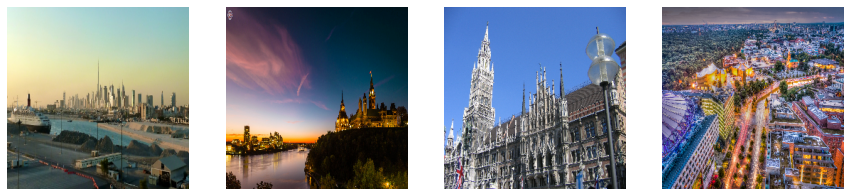

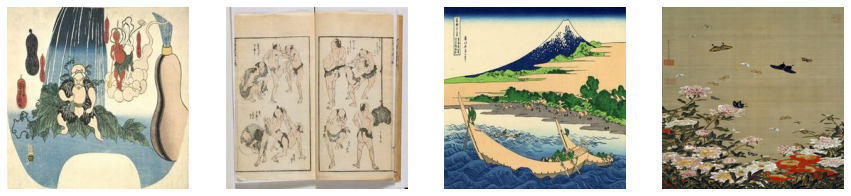

In [20]:
plt.figure(figsize=(15,15))
for i, img in enumerate(train_pic.skip(36).take(4)):
    plt.subplot(1,4,i+1)
    plt.imshow(img[0]*.5 +.5)
    plt.axis('off')
plt.show()

plt.figure(figsize=(15,15))
for i, img in enumerate(train_print.take(4)):
    plt.subplot(1,4,i+1)
    plt.imshow(img[0]*.5 +.5)
    plt.axis('off')
plt.show()

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
to_print = generator_g(sample_pic)
to_pic = generator_f(sample_print)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_pic, to_print, sample_print, to_pic]
title = ['Pic', 'To Print', 'Print', 'To Pic']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    # We pass the denormalized photo so that some result can be seen, since the model is not trained
    if i % 2 == 0:
        plt.imshow(denormalize(imgs[i][0]))
    else:
        plt.imshow(denormalize(imgs[i][0]*contrast))
plt.show()

In [ ]:
# Untrained discriminators

plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real print?')
plt.imshow(discriminator_y(denormalize(sample_print))[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real pic?')
plt.imshow(discriminator_x(denormalize(sample_pic))[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
# We pass the denormalized photo so that some result can be seen, since the model is not trained
pic = denormalize(sample_pic[0,...])
example_gen_output_y = generator_g(pic[tf.newaxis,...], training=False)
example_disc_out = discriminator_y(example_gen_output_y, training=False)

plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(pic, vmin=0, vmax=255) 
plt.title("Original Picture")

plt.subplot(1,3,2)
plt.imshow(example_gen_output_y[0,...]) 
plt.title("Generated Print")

plt.subplot(1,3,3)
m = example_disc_out[0,...,-1].numpy()*1000
im = plt.imshow(m, vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Is this a Print?')

plt.show()

## Loss Functions

In [ ]:
LAMBDA = 12 

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## Training

In [ ]:
EPOCHS = 100

def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_pic, train_print)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
    n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_pic) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_pic)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

In [ ]:
for inp in test_pic.take(15):
    generate_images(generator_g, inp)